# Enunciado

1) Escolha um dataset do Kaggle de série temporal.

2) Descreva as colunas do dataset.

3) Escolha uma métrica e justifique sua escolha de acordo com o tipo de problema tratado.

4) Implemente um modelo de predição usando uma RNN e apresente os resultados de treinamento de acordo com a métrica selecionada, e um gráfico comparando o valor real com o valor predito.

5) Entregue seu trabalho em formato IPYNB no GitHub com acesso liberado ao professor.


# Configuração de ambiente

In [1]:
!pip install numpy

In [2]:
!pip install d2l

In [3]:
import os
import tensorflow as tf
from d2l import tensorflow as d2l

In [88]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
 %matplotlib inline
import pandas as pd

## 1) Escolha um dataset do Kaggle de série temporal.

O dataset escolhido foi o [Time Series starter dataset](https://www.kaggle.com/datasets/podsyp/time-series-starter-dataset?resource=download).

In [239]:
df = pd.read_csv('/content/drive/MyDrive/Banco de Dados/Month_Value_1.csv')
df.head()

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,01.01.2015,1.601007e+07,12729.0,1257.763541,30024676.0
1,01.02.2015,1.580759e+07,11636.0,1358.507000,30024676.0
2,01.03.2015,2.204715e+07,15922.0,1384.697024,30024676.0
3,01.04.2015,1.881458e+07,15227.0,1235.606705,30024676.0
4,01.05.2015,1.402148e+07,8620.0,1626.621765,30024676.0


# 2) Descreva as colunas do dataset.

O dataset possui as colunas:
- Period: tipo objeto, representa o dia referente ao registro.
- Revenue: tipo float, trata-se da receita da empresa.
- Sales_quantity: também tipo float, esse se refere a quantidade vendida.
- Average_cost: assim copmo os anteriores, são tipo float e representam o custo médio da empresa.
- The_average_annual_payroll_of_the_region: também tipo float, é o valor da folha de pagamento anual média da região.


In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 5 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Period                                    96 non-null     object 
 1   Revenue                                   64 non-null     float64
 2   Sales_quantity                            64 non-null     float64
 3   Average_cost                              64 non-null     float64
 4   The_average_annual_payroll_of_the_region  64 non-null     float64
dtypes: float64(4), object(1)
memory usage: 3.9+ KB


# 3) Escolha uma métrica e justifique sua escolha de acordo com o tipo de problema tratado.

Erro Médio Quadrático (Mean Squared Error - MSE) foi escolhido como métrica pela capacidade de identificar as discrepâncias entre os valores reais e as previsões do modelo. O MSE calcula a média dos erros ao quadrado, o que amplifica as diferenças maiores, tornando-o útil para séries temporais, principalmente em situações como o dataset escolhido, em que se trata de previsões financeiras, no caso a receita (coluna Revenue).

# 4) Implemente um modelo de predição usando uma RNN e apresente os resultados de treinamento de acordo com a métrica selecionada, e um gráfico comparando o valor real com o valor predito.

### Visualização dos dados

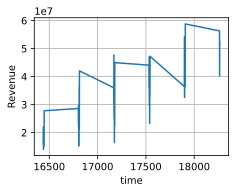

In [241]:
time = pd.to_datetime(df['Period'])
df.set_index('Period', inplace=True)
x = df['Revenue']
d2l.plot(time, [x], 'time', 'Revenue')

### Normalização dos dados

In [242]:
df = df.dropna()

In [243]:
features = ['Sales_quantity', 'Average_cost', 'The_average_annual_payroll_of_the_region']
target = 'Revenue'

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, index=df.index, columns=df.columns)

### Janelas temporais

In [244]:
df_scaled = pd.DataFrame(df_scaled, index=df.index, columns=df.columns)

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        dataX.append(dataset[i:(i + look_back), :-1])
        dataY.append(dataset[i + look_back, -1])
    return np.array(dataX), np.array(dataY)

look_back = 10
data = df_scaled[features + [target]].values
X, y = create_dataset(data, look_back)

new_time = df_scaled.index.values
new_time = new_time[look_back:len(new_time) - 1]

X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

In [245]:
df_scaled

,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
Period,,,,
01.01.2015,0.044453,0.148378,0.101596,1.000000
01.02.2015,0.039926,0.111645,0.171134,1.000000
01.03.2015,0.179405,0.255688,0.189211,1.000000
01.04.2015,0.107144,0.232331,0.086302,1.000000
01.05.2015,0.000000,0.010284,0.356200,1.000000
...,...,...,...,...
01.12.2019,1.000000,1.000000,0.298770,0.944179
01.01.2020,0.944827,0.634179,0.662684,0.625820
01.02.2020,0.585755,0.510670,0.414481,0.625820


### Divisão de treino e de teste

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

### Modelo RNN

In [247]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(look_back, X.shape[2])))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [248]:
history = model.fit(X_train, y_train, epochs=20, batch_size=16)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.2092
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1268
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0693
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0541
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0591
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0448
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0311 
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0382 
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0352
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0335
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0338
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0355
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0411
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0331 
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0331 
Epoch 16/20
3/3 ━━━━━━━━━━━━━━

### Previsão

In [249]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


### Métrica: erro médio quadrático

In [250]:
train_score = mean_squared_error(y_train, train_predict)
test_score = mean_squared_error(y_test, test_predict)

print(f'Train Score (MSE): {train_score:.4f}')
print(f'Test Score (MSE): {test_score:.4f}')

Train Score (MSE): 0.0324
Test Score (MSE): 0.0847


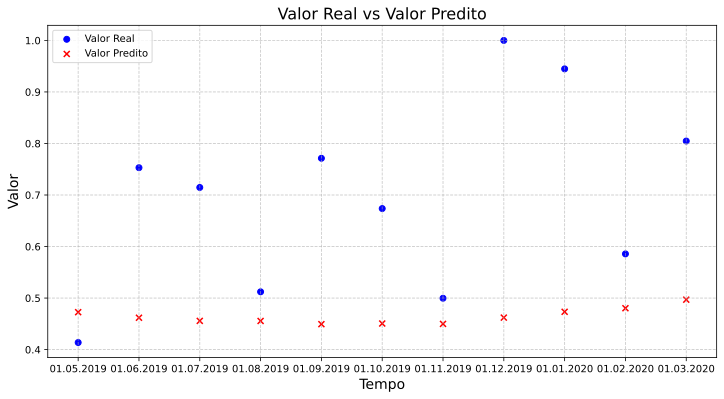

In [254]:
plt.figure(figsize=(12, 6))
plt.scatter(new_time[len(X_train):], y_test, color='blue', label='Valor Real', marker='o')
plt.scatter(new_time[len(X_train):], test_predict, color='red', label='Valor Predito', marker='x')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Tempo', fontsize=14)
plt.ylabel('Valor', fontsize=14)
plt.title('Valor Real vs Valor Predito', fontsize=16)
plt.legend(loc='upper left')

plt.show()